# Train a miniGPT language model with JAX

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/jax-ml/jax-ai-stack/blob/main/docs/source/JAX_for_LLM_pretraining.ipynb"><img src="https://www.kaggle.com/static/images/logos/kaggle-logo-transparent-300.png" height="32" width="70"/>Run in Kaggle</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/jax-ml/jax-ai-stack/blob/main/docs/source/JAX_for_LLM_pretraining.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/jax-ml/jax-ai-stack/blob/main/docs/source/JAX_for_LLM_pretraining.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Introduction

Welcome to this comprehensive tutorial on training a miniGPT language model using JAX and its AI ecosystem. This hands-on guide will walk you through the complete process of building, training, and optimizing a small but functional GPT-style language model.

**What you'll learn:**

This tutorial demonstrates how to use JAX, [Flax NNX](http://flax.readthedocs.io) and [Optax](http://optax.readthedocs.io) for language model (pre)training using data and tensor [parallelism](https://docs.jax.dev/en/latest/notebooks/Distributed_arrays_and_automatic_parallelization.html). It was originally inspired by the [Keras miniGPT tutorial](https://keras.io/examples/generative/text_generation_with_miniature_gpt/).

By the end of this tutorial, you will be able to:

- **Understand JAX's parallelism capabilities**: Learn how to leverage data and tensor parallelism to distribute training across multiple TPU/GPU devices
- **Build transformer models with Flax NNX**: Define a GPT-style architecture using the modern Flax NNX API
- **Process data efficiently with Grain**: Load and preprocess training data using Google's Grain data loading library
- **Optimize models with Optax**: Implement training loops using JAX's gradient transformation library
- **Train on cloud TPUs or GPUs**: Execute training using available accelerators (TPU, GPU) , while still maintaining the ability to run on CPU if needed
- **Fine-tune with LoRA**: Apply parameter-efficient fine-tuning using the Tunix library
- **Profile and optimize**: Use JAX's profiling tools to identify bottlenecks and tune hyperparameters

**What to expect:**

You'll train a miniGPT model from scratch on the TinyStories dataset, watch it progress from generating random text to coherent short stories, and then fine-tune it on Shakespeare's works to change its writing style. The entire training process takes approximately 20 minutes on a free Colab TPU.

**Prerequisites:**

If you are new to JAX for AI, check out the [introductory tutorial](https://docs.jaxstack.ai/en/latest/neural_net_basics.html), which covers neural network building with [Flax NNX](https://flax.readthedocs.io/en/latest/nnx_basics.html). Basic familiarity with Python, neural networks, and transformers is helpful but not required.

## Setup

JAX installation is covered in [this guide](https://jax.readthedocs.io/en/latest/installation.html) on the JAX documentation site. We will use [Tiktoken](https://github.com/openai/tiktoken) for tokenization and [Grain](https://google-grain.readthedocs.io/en/latest/index.html) for data loading.

In [ ]:
!pip install -Uq tiktoken jax-ai-stack[grain] matplotlib

**Note:** If you are using [Kaggle](https://www.kaggle.com/), select the free TPU v5e-8 as the hardware accelerator. If you are using [Google Colab](https://colab.research.google.com/), select the free Google Cloud TPU v5e-1 as the hardware accelerator. You may also use Google Cloud TPUs.

Check the available JAX devices, or [`jax.Device`](https://jax.readthedocs.io/en/latest/_autosummary/jax.Device.html), with [`jax.devices()`](https://jax.readthedocs.io/en/latest/_autosummary/jax.devices.html). The output of the cell below will show a list of 8 (eight) devices.

In [ ]:
import jax
jax.devices()

/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:93: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0)]

In [ ]:
# Check if an accelerator (GPU/TPU) is available
accelerator_available = any(d.platform in ('gpu', 'tpu') for d in jax.devices())

if not accelerator_available:
    import warnings
    warnings.warn(
        "WARNING: No GPU or TPU accelerator found. This notebook will still run, but using only the CPU can be much slower—training may take longer than intended.\n"
        "For the best experience, it is highly recommended to use an accelerator:\n"
        "  • Kaggle: Go to Settings → Accelerator → Choose GPU or TPU\n"
        "  • Colab: Go to Runtime → Change runtime type → Select GPU or TPU\n"
        "You can continue, but expect reduced performance."
    )

Get the [TinyStories dataset from Hugging Face](https://huggingface.co/datasets/roneneldan/TinyStories). We only use the training split.

In [ ]:
!wget https://huggingface.co/datasets/roneneldan/TinyStories/resolve/main/TinyStories-train.txt?download=true -O TinyStories-train.txt

--2026-02-06 14:30:53--  https://huggingface.co/datasets/roneneldan/TinyStories/resolve/main/TinyStories-train.txt?download=true
Resolving huggingface.co (huggingface.co)... 18.161.6.33, 18.161.6.46, 18.161.6.107, ...
Connecting to huggingface.co (huggingface.co)|18.161.6.33|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://us.gcp.cdn.hf.co/xet-bridge-us/645e8da96320b0efe40ade7a/e2a1497efc1aa51b2da2a849d5dd2cd153d5bc024901afeade7e35379d8f7b52?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27TinyStories-train.txt%3B+filename%3D%22TinyStories-train.txt%22%3B&response-content-type=text%2Fplain&Expires=1770391853&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiRXBvY2hUaW1lIjoxNzcwMzkxODUzfX0sIlJlc291cmNlIjoiaHR0cHM6Ly91cy5nY3AuY2RuLmhmLmNvL3hldC1icmlkZ2UtdXMvNjQ1ZThkYTk2MzIwYjBlZmU0MGFkZTdhL2UyYTE0OTdlZmMxYWE1MWIyZGEyYTg0OWQ1ZGQyY2QxNTNkNWJjMDI0OTAxYWZlYWRlN2UzNTM3OWQ4ZjdiNTJcXD9yZXNwb25zZS1jb250ZW50LWRpc3Bvc2l0aW9uPS

Import the necessary modules, including JAX NumPy, Flax NNX, Optax, Grain, pandas, and Tiktoken:

In [ ]:
import jax
import jax.numpy as jnp
from jax.sharding import PartitionSpec as P, NamedSharding

import flax.nnx as nnx
import optax

from dataclasses import dataclass
import grain.python as pygrain
import tiktoken
import time

## JAX: High-performance array computing

[JAX](https://jax.readthedocs.io) is a Python library for high-performance numerical computing and machine learning research. It combines the familiar NumPy API with powerful program transformations to enable automatic differentiation, vectorization, and parallelization.

**Key features of JAX:**

- **NumPy compatibility**: JAX provides `jax.numpy`, a drop-in replacement for NumPy that runs on accelerators like GPUs and TPUs
- **Automatic differentiation**: The `jax.grad()` function computes gradients automatically, making it easy to implement gradient-based optimization
- **JIT compilation**: `jax.jit()` compiles Python functions to optimized machine code for faster execution
- **Automatic parallelization**: JAX can automatically distribute computations across multiple devices using SPMD (Single Program, Multiple Data) parallelism
- **Functional programming**: JAX encourages pure functions, which enables reliable transformations and better performance

For training large language models like our miniGPT, JAX's automatic parallelization capabilities are particularly valuable. They allow us to efficiently utilize multiple GPU or TPU cores without manually managing device placement and communication, making the most of whichever accelerator hardware is available.

The three core JAX transforms you'll need understand are:
- **[`jax.jit`](https://jax.readthedocs.io/en/latest/jax-101/02-jitting.html)**: Just-in-time compilation via XLA for fast execution

In [ ]:
def slow_fn(x):
    for _ in range(5):
        x = x @ x
    return x

fast_fn = jax.jit(slow_fn)

x = jnp.ones((1000, 1000))

# The first call to the jitted function triggers compilation for the given input shape/dtype
# (in this case, shape (1000, 1000)). Subsequent calls with the same shape/dtype are fast,
# as they use the cached compiled executable.
fast_fn(x).block_until_ready()

%timeit slow_fn(x).block_until_ready()
%timeit fast_fn(x).block_until_ready()

392 µs ± 17 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
216 µs ± 5.67 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


- **[`jax.grad`](https://jax.readthedocs.io/en/latest/jax-101/04-advanced-autodiff.html)**: Automatic differentiation for computing gradients

In [ ]:
def loss(x):
    return jnp.sum(x ** 2)

grad_loss = jax.grad(loss)

x = jnp.array([1.0, 2.0, 3.0])
print(f"x = {x}")
print(f"loss(x) = {loss(x)}")
print(f"grad(loss)(x) = {grad_loss(x)}")  # Derivative of x^2 is 2x

x = [1. 2. 3.]
loss(x) = 14.0
grad(loss)(x) = [2. 4. 6.]


- **[`jax.vmap`](https://jax.readthedocs.io/en/latest/jax-101/03-vectorization.html)**: Automatic vectorization to batch operations efficiently

In [ ]:
# Function that operates on a single vector
def normalize(x):
    return x / jnp.linalg.norm(x)

# Create a batch of vectors
batch = jnp.array([[1.0, 2.0, 3.0],
                   [4.0, 5.0, 6.0],
                   [7.0, 8.0, 9.0]])

# vmap automatically vectorizes over the batch dimension
batch_normalize = jax.vmap(normalize)
print(batch_normalize(batch))

[[0.26726124 0.5345225  0.8017837 ]
 [0.45584232 0.5698029  0.6837635 ]
 [0.50257075 0.57436657 0.6461624 ]]


For a deeper introduction to JAX fundamentals, see the [JAX 101 tutorials](https://jax.readthedocs.io/en/latest/jax-101/index.html).

## Define the miniGPT model with NNX and JAX automatic parallelism

### NNX: A JAX-based neural network library

[Flax NNX](https://flax.readthedocs.io/en/latest/nnx_basics.html) is the next-generation neural network library for JAX, designed to make building and training models more intuitive and Pythonic. NNX is part of the Flax ecosystem and represents a modernized approach to neural network development.

**Why NNX?**

- **Stateful and intuitive**: Unlike the original Flax (Linen), NNX uses a stateful, object-oriented API that feels more natural for Python developers
- **Familiar syntax**: Define models using standard Python classes with `__init__` and `__call__` methods, similar to PyTorch
- **Seamless JAX integration**: NNX works smoothly with JAX transformations like `jit`, `grad`, and `vmap`
- **Built-in modules**: Provides common layers like `nnx.Linear`, `nnx.MultiHeadAttention`, and `nnx.LayerNorm` out of the box
- **Flexible state management**: Easily separate and manage different types of state (parameters, batch statistics, etc.)

In [ ]:
# A simple two-layer MLP in Flax NNX
class SimpleMLP(nnx.Module):
    def __init__(self, in_features, hidden_size, out_features, rngs: nnx.Rngs):
        self.linear1 = nnx.Linear(in_features, hidden_size, rngs=rngs)
        self.linear2 = nnx.Linear(hidden_size, out_features, rngs=rngs)

    def __call__(self, x):
        x = self.linear1(x)
        x = nnx.relu(x)
        x = self.linear2(x)
        return x

# Create model and run a forward pass
simple_model = SimpleMLP(in_features=3, hidden_size=16, out_features=2, rngs=nnx.Rngs(0))
x = jnp.ones((4, 3))  # batch of 4 samples, 3 features each
print(f"Output shape: {simple_model(x).shape}")  # (4, 2)

Output shape: (4, 2)


In this tutorial, we'll use NNX to define our transformer architecture, leveraging its clean API to build the attention mechanisms, feed-forward networks, and embeddings that make up our miniGPT model.

### Leveraging JAX's data and tensor parallelism

One of the most powerful features of JAX is [device parallelism](https://docs.jax.dev/en/latest/notebooks/Distributed_arrays_and_automatic_parallelization.html) for SPMD.

- The data parallelism technique enables, for example, the training data to run via multiple parts (this is called sharding) - batches - in parallel and simultaneously across different devices, such as GPUs and Google TPUs. This allows to use larger batch sizes to speed up training.
- Tensor parallelism allows us to split the model parameter tensors across several devices (sharding model tensors).
- You can learn more about the basics of JAX parallelism in more detail in the [Introduction to parallel programming](https://jax.readthedocs.io/en/latest/sharded-computation.html) on the JAX documentation site.

In this example, we'll utilize a 4-way data parallel and 2-way tensor parallel setup, which is aligned with Kaggle TPU v5e-8 or newer GCP TPUs chips.

Note that as of October 2025, free-tier Colab only offers TPU v5e-1, which can no longer support SPMD.

### jax.sharding.Mesh

[`jax.sharding.Mesh`](https://jax.readthedocs.io/en/latest/jax.sharding.html#jax.sharding.Mesh) is a multidimensional NumPy array of JAX devices, where each axis of the mesh has a name, such as `'x'` or `'y'`. This will help encapsulate the information about the TPU resource organization for distributing computations across the devices.

Our `Mesh` will have two arguments:
- `devices`: This will take the value of [`jax.make_mesh((4, 2), ('batch', 'model'))`](https://jax.readthedocs.io/en/latest/jax.experimental.mesh_utils.html), enabling us to build a device mesh. It is a NumPy ndarray with JAX devices (a list of devices from the JAX backend as obtained from [`jax.devices()`](https://jax.readthedocs.io/en/latest/_autosummary/jax.devices.html#jax.devices))..
- `axis_names`, where:
  - `batch`: 4 devices along the first axis - i.e. sharded into 4 - for data parallelism; and
  - `model`: 2 devices along the second axis - i.e. sharded into 2 -  for tensor parallism

This matches the structure in the Kaggle TPU v5e setup.

Let's instantiate `Mesh` as `mesh` and declare the TPU configuration to define how data and model parameters are distributed across the devices:

In [ ]:
# Create a `Mesh` object representing TPU device arrangement.
# The mesh defines how we distribute computation across devices.

if jax.device_count() == 8:
    # For Kaggle TPU v5e-8 or similar 8-core TPUs:
    # Split 8 devices into a 4x2 grid for data and model parallelism
    mesh = jax.make_mesh((4, 2), ('batch', 'model'))

    # Alternative: Use 8-way data parallelism (no model parallelism)
    # Uncomment the line below to experiment with this configuration:
    # mesh = jax.make_mesh((8, 1), ('batch', 'model'))

elif jax.device_count() == 1:
    # For free-tier Colab TPU v5e-1 (single core)
    # No parallelism is possible, but we still create a mesh for consistency
    mesh = jax.make_mesh((1, 1), ('batch', 'model'))

else:
    # For other device counts, use all devices for data parallelism
    mesh = jax.make_mesh((jax.device_count(), 1), ('batch', 'model'))

print(f"Created mesh with {jax.device_count()} devices: {mesh}")
print(f"Mesh shape: {mesh.shape} (batch={mesh.shape['batch']}, model={mesh.shape['model']})")

Created mesh with 1 devices: Mesh('batch': 1, 'model': 1, axis_types=(Auto, Auto))
Mesh shape: OrderedDict({'batch': 1, 'model': 1}) (batch=1, model=1)


We will use the GPT-2 tokenizer from the [Tiktoken](https://github.com/openai/tiktoken) library:

In [ ]:
tokenizer = tiktoken.get_encoding("gpt2")

To leverage model parallelism, we need to instruct the JAX compiler how to shard the model tensors across the TPU devices. We'll use Flax NNX's [`flax.nnx.with_partitioning`](https://flax.readthedocs.io/en/latest/api_reference/flax.nnx/spmd.html#flax.nnx.with_partitioning) to let each model layer know that the model weights or tensors need to be sharded according to our specification. We need to do this for every tensor/layer in the model.

`nnx.with_partitioning` will take two arguments, such as the `initializer` (e.g. [`flax.nnx.initializers.xavier_uniform`](https://flax.readthedocs.io/en/latest/api_reference/flax.nnx/nn/initializers.html#flax.nnx.initializers.xavier_uniform) and [`flax.nnx.initializers.zeros_init`](https://flax.readthedocs.io/en/latest/api_reference/flax.nnx/nn/initializers.html#flax.nnx.initializers.zeros_init)), and a sharding tuple (e.g. `(None, 'model')` in our case) wrapped in [`jax.sharding.PartitionSpec`](https://docs.jax.dev/en/latest/jax.sharding.html#jax.sharding.PartitionSpec). The sharding tuple describe how to shard a tensor across, for example, the `model` axis or be replicated on other dimensions (which is denoted by `None`).

For a more detailed discussion of Flax NNX sharding, please refer to [this SPMD guide](https://flax.readthedocs.io/en/latest/guides/flax_gspmd.html).

In [ ]:
# Define a triangular mask for causal attention with `jax.numpy.tril` and `jax.numpy.ones`.
def causal_attention_mask(seq_len):
    return jnp.tril(jnp.ones((seq_len, seq_len)))


class TransformerBlock(nnx.Module):
    """ A single Transformer block.

    Each Transformer block processes input sequences via self-attention and feed-forward networks.

    Args:
        embed_dim (int): Embedding dimensionality.
        num_heads (int): Number of attention heads.
        ff_dim (int): Dimensionality of the feed-forward network.
        rngs (flax.nnx.Rngs): A Flax NNX stream of JAX PRNG keys.
        rate (float): Dropout rate. Defaults to 0.1.
    """
    def __init__(self, embed_dim: int, num_heads: int, ff_dim: int, *, rngs: nnx.Rngs, rate: float = 0.1):
        # Sharding specs for model parallelism
        kernel_sharding = P(None, 'model')
        bias_sharding = P('model')

        # Multi-Head Attention
        self.mha = nnx.MultiHeadAttention(
            num_heads=num_heads,
            in_features=embed_dim,
            kernel_init=nnx.with_partitioning(nnx.initializers.xavier_uniform(), kernel_sharding),
            bias_init=nnx.with_partitioning(nnx.initializers.zeros_init(), bias_sharding),
            rngs=rngs
        )

        # First residual path
        self.dropout1 = nnx.Dropout(rate=rate, rngs=rngs)
        self.layer_norm1 = nnx.LayerNorm(
            epsilon=1e-6, num_features=embed_dim,
            scale_init=nnx.with_partitioning(nnx.initializers.ones_init(), bias_sharding),
            bias_init=nnx.with_partitioning(nnx.initializers.zeros_init(), bias_sharding),
            rngs=rngs
        )

        # Feed-forward network
        self.linear1 = nnx.Linear(
            in_features=embed_dim, out_features=ff_dim,
            kernel_init=nnx.with_partitioning(nnx.initializers.xavier_uniform(), kernel_sharding),
            bias_init=nnx.with_partitioning(nnx.initializers.zeros_init(), bias_sharding),
            rngs=rngs
        )
        self.linear2 = nnx.Linear(
            in_features=ff_dim, out_features=embed_dim,
            kernel_init=nnx.with_partitioning(nnx.initializers.xavier_uniform(), kernel_sharding),
            bias_init=nnx.with_partitioning(nnx.initializers.zeros_init(), bias_sharding),
            rngs=rngs
        )

        # Second residual path
        self.dropout2 = nnx.Dropout(rate=rate, rngs=rngs)
        self.layer_norm2 = nnx.LayerNorm(
            epsilon=1e-6, num_features=embed_dim,
            scale_init=nnx.with_partitioning(nnx.initializers.ones_init(), bias_sharding),
            bias_init=nnx.with_partitioning(nnx.initializers.zeros_init(), bias_sharding),
            rngs=rngs
        )

    # Apply the Transformer block to the input sequence.
    def __call__(self, inputs, training: bool = False):
        input_shape = inputs.shape
        _, seq_len, _ = input_shape

        # Instantiate the causal attention mask.
        mask = causal_attention_mask(seq_len)

        # Apply Multi-Head Attention with the causal attention mask.
        attention_output = self.mha(
            inputs_q=inputs,
            mask=mask,
            decode=False
        )
        # Apply the first dropout.
        attention_output = self.dropout1(attention_output, deterministic=not training)
        # Apply the first layer normalization.
        out1 = self.layer_norm1(inputs + attention_output)

        # The feed-forward network.
        # Apply the first linear transformation.
        ffn_output = self.linear1(out1)
        # Apply the ReLU activation with `flax.nnx.relu`.
        ffn_output = nnx.relu(ffn_output)
        # Apply the second linear transformation.
        ffn_output = self.linear2(ffn_output)
        # Apply the second dropout.
        ffn_output = self.dropout2(ffn_output, deterministic=not training)
        # Apply the second layer normalization and return the output of the Transformer block.
        return self.layer_norm2(out1 + ffn_output)


class TokenAndPositionEmbedding(nnx.Module):
    """ Combines token embeddings (words in an input sentence) with
    positional embeddings (the position of each word in a sentence).

    Args:
        maxlen (int): Matimum sequence length.
        vocal_size (int): Vocabulary size.
        embed_dim (int): Embedding dimensionality.
        rngs (flax.nnx.Rngs): A Flax NNX stream of JAX PRNG keys.
    """
    def __init__(self, maxlen: int, vocab_size: int, embed_dim: int, *, rngs: nnx.Rngs):
        # Initialize token embeddings (using `flax.nnx.Embed`).
        # Each unique word has an embedding vector.
        self.token_emb = nnx.Embed(num_embeddings=vocab_size, features=embed_dim, rngs=rngs)
        # Initialize positional embeddings (using `flax.nnx.Embed`).
        self.pos_emb = nnx.Embed(num_embeddings=maxlen, features=embed_dim, rngs=rngs)

    # Takes a token sequence (integers) and returns the combined token and positional embeddings.
    def __call__(self, x):
        # Generate a sequence of positions for the input tokens.
        positions = jnp.arange(0, x.shape[1])[None, :]
        # Look up the positional embeddings for each position in the input sequence.
        position_embedding = self.pos_emb(positions)
        # Look up the token embeddings for each token in the input sequence.
        token_embedding = self.token_emb(x)
        # Combine token and positional embeddings.
        return token_embedding + position_embedding


class MiniGPT(nnx.Module):
    """ A miniGPT transformer model, inherits from `flax.nnx.Module`.

    Args:
        maxlen (int): Maximum sequence length.
        vocab_size (int): Vocabulary size.
        embed_dim (int): Embedding dimensionality.
        num_heads (int): Number of attention heads.
        feed_forward_dim (int): Dimensionality of the feed-forward network.
        num_transformer_blocks (int): Number of transformer blocks. Each block contains attention and feed-forward networks.
        rngs (nnx.Rngs): A Flax NNX stream of JAX PRNG keys.
    """
    # Initialize miniGPT model components.
    def __init__(self, maxlen: int, vocab_size: int, embed_dim: int, num_heads: int,
                 feed_forward_dim: int, num_transformer_blocks: int, rngs: nnx.Rngs):
        # Initiliaze the `TokenAndPositionEmbedding` that combines token and positional embeddings.
        self.embedding_layer = TokenAndPositionEmbedding(
                    maxlen, vocab_size, embed_dim, rngs=rngs
                )
        # Create a Sequential container of `TransformerBlock` instances.
        # Each block processes input sequences using attention and feed-forward networks.
        # Use nnx.Sequential instead of a plain list for proper NNX 0.12.0+ compatibility
        self.transformer_blocks = nnx.Sequential(*[TransformerBlock(
            embed_dim, num_heads, feed_forward_dim, rngs=rngs
        ) for _ in range(num_transformer_blocks)])
        # Initialize the output `flax.nnx.Linear` layer producing logits over the vocabulary for next-token prediction.
        self.output_layer = nnx.Linear(
            in_features=embed_dim, out_features=vocab_size,
            kernel_init=nnx.with_partitioning(nnx.initializers.xavier_uniform(), P(None, 'model')),
            bias_init=nnx.with_partitioning(nnx.initializers.zeros_init(), P('model')),
            rngs=rngs
        )

    def __call__(self, inputs, training: bool = False):
        # Pass the input tokens through the `embedding_layer` to get token embeddings.
        # Apply each transformer block sequentially to the embedded input, use the `training` flag for the behavior of `flax.nnx.Dropout`.
        x = self.embedding_layer(inputs)
        # nnx.Sequential automatically applies each block in sequence
        # We need to pass the training flag to each block manually
        for block in self.transformer_blocks.layers:
            x = block(x, training=training)
        # Pass the output of the transformer blocks through the output layer,
        # and obtain logits for each token in the vocabulary (for next token prediction).
        outputs = self.output_layer(x)
        return outputs

    def get_model_input(self):
        return dict(inputs=jnp.zeros((batch_size, maxlen), dtype=jnp.int32), training=False)

    @nnx.jit
    def sample_from(self, rng_key, logits):
        logits, indices = jax.lax.top_k(logits, k=top_k)
        return jax.random.choice(rng_key, indices, p=nnx.softmax(logits))

    @nnx.jit
    def generate_step(self, rng_key, padded_tokens, sample_index):
        logits = self(padded_tokens)
        return self.sample_from(rng_key, logits[0][sample_index])

    def generate_text(self, max_tokens, start_tokens):
        generated = []
        rng_key = jax.random.PRNGKey(0)
        print(tokenizer.decode(start_tokens), flush=True, end='')

        for i in range(max_tokens):
            sample_index = len(start_tokens) + len(generated) - 1
            rng_key, step_key = jax.random.split(rng_key)

            current_seq = start_tokens + generated
            padded = jnp.array(current_seq + [0] * (maxlen - len(current_seq)))[None, :]
            next_token = int(self.generate_step(step_key, padded, sample_index))

            end_token = tokenizer.encode('<|endoftext|>', allowed_special={'<|endoftext|>'})[0]
            if next_token == end_token:
                break

            generated.append(next_token)
            print(tokenizer.decode([next_token]), flush=True, end='')

        return tokenizer.decode(start_tokens + generated)


# Creates the miniGPT model with 4 transformer blocks.
def create_model(rngs):
    return MiniGPT(maxlen, vocab_size, embed_dim, num_heads, feed_forward_dim, num_transformer_blocks=4, rngs=rngs)

Set some hyperparameters.

In [ ]:
# Model architecture hyperparameters
vocab_size = tokenizer.n_vocab              # Size of GPT-2 vocabulary
num_transformer_blocks = 4                  # Number of transformer layers
maxlen = 128                                # Maximum sequence length
embed_dim = 128                             # Embedding dimension
num_heads = 4                               # Number of attention heads
feed_forward_dim = 256                      # Hidden dimension in feed-forward network

# Training hyperparameters
batch_size = 32                             # Batch size
num_epochs = 1                              # Number of passes through the dataset
top_k = 10                                  # Top-k sampling for text generation

## Grain: Load and preprocess the data

[Grain](https://google-grain.readthedocs.io/en/latest/) is Google's high-performance data loading library designed specifically for machine learning workloads in JAX. It provides efficient data pipelines that can keep up with the demanding throughput requirements of modern accelerators like TPUs and GPUs.

**Why Grain for data loading?**

- **Performance optimized**: Grain is designed from the ground up for high-throughput data loading, minimizing bottlenecks between data processing and model training
- **Deterministic and reproducible**: Grain ensures deterministic iteration order even with shuffling and multiple workers, which is crucial for reproducible experiments
- **JAX integration**: Seamlessly works with JAX's device parallelism, automatically handling data sharding across multiple devices
- **Flexible transformations**: Provides composable operations for batching, shuffling, and preprocessing data
- **Multi-epoch support**: Built-in support for iterating over datasets multiple times without manual reinitialization

**Key Grain concepts:**

In this tutorial, we use three main Grain components:

1. **Data source**: A custom `TextDataset` class that tokenizes and pads text sequences to a fixed length
2. **Sampler**: An `IndexSampler` that determines the order in which examples are accessed from the data source
3. **DataLoader**: Combines the data source, sampler, and operations (like batching) into an efficient pipeline

Grain handles the complexity of data loading, allowing us to focus on model development while ensuring our TPUs stay fully utilized during training.

In [ ]:
@dataclass
class TextDataset:
    """A simple dataset for tokenized text sequences."""
    data: list
    maxlen: int

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx: int):
        # Tokenize and truncate
        encoding = tokenizer.encode(self.data[idx], allowed_special={'<|endoftext|>'})[:self.maxlen]
        # Pad to maxlen
        return encoding + [0] * (self.maxlen - len(encoding))


def load_and_preprocess_data(file_path, batch_size, maxlen):
    """Load the TinyStories dataset and create a Grain DataLoader."""

    # Read the file
    with open(file_path, 'r') as f:
        text = f.read(1 << 29)

    # Split into stories
    stories = text.split('<|endoftext|>')
    stories = [story + '<|endoftext|>' for story in stories if story.strip()]
    print(f"Loaded {len(stories):,} stories")

    dataset = TextDataset(stories, maxlen)

    sampler = pygrain.IndexSampler(
        len(dataset),
        shuffle=False,
        seed=42,
        shard_options=pygrain.NoSharding(),
        num_epochs=num_epochs,
    )

    dl = pygrain.DataLoader(
        data_source=dataset,
        sampler=sampler,
        operations=[pygrain.Batch(batch_size=batch_size, drop_remainder=True)],
    )

    return dl

In [ ]:
# @title [hidden cell; used for testing]
# This cell is run only in the JAX AI Stack's CI testing and should otherwise be ignored.
import os
AI_STACK_TEST_MODE = os.getenv('AI_STACK_TEST_MODE') == 'true'

if AI_STACK_TEST_MODE:
    num_transformer_blocks = 2
    maxlen = 16
    embed_dim = 16
    num_heads = 2
    feed_forward_dim = 8

    def load_and_preprocess_data(file_path, batch_size, maxlen):
        del file_path

        @dataclass
        class TestTextDataset:
            maxlen: int

            def __len__(self):
                return 64

            def __getitem__(self, idx: int):
                encoding = jax.random.randint(jax.random.key(idx), [self.maxlen], minval=0, maxval=1e6)
                return jnp.unstack(encoding)

        dataset = TestTextDataset(maxlen)

        sampler = pygrain.IndexSampler(
            len(dataset),
            shuffle=False,
            seed=42,
            shard_options=pygrain.NoSharding(),
            num_epochs=num_epochs,
        )

        dl = pygrain.DataLoader(
            data_source=dataset,
            sampler=sampler,
            operations=[pygrain.Batch(batch_size=batch_size, drop_remainder=True)],
        )

        return dl

In [ ]:
# Create the data loader
# This will load, tokenize, and batch the TinyStories dataset
print(f"Loading TinyStories dataset with batch_size={int(batch_size)}, maxlen={maxlen}...")
text_dl = load_and_preprocess_data('TinyStories-train.txt', int(batch_size), maxlen)
print("Dataset loaded successfully!")

Loading TinyStories dataset with batch_size=32, maxlen=128...
Loaded 589,692 stories
Dataset loaded successfully!


## Defining the loss function and training step function

In [ ]:
def loss_fn(model, batch):
    """Compute the cross-entropy loss for language modeling.

    Args:
        model: The MiniGPT model
        batch: A tuple of (input_tokens, target_tokens)

    Returns:
        A tuple of (loss, logits) where:
        - loss: Scalar cross-entropy loss
        - logits: Model predictions (returned as auxiliary output for metrics)
    """
    input_tokens, target_tokens = batch

    # Forward pass: get logits for each position
    logits = model(input_tokens)

    # Compute cross-entropy loss between predictions and targets
    # This measures how well the model predicts the next token
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits,
        labels=target_tokens
    ).mean()

    return loss, logits


@nnx.jit  # JIT-compile for performance (runs once, then cached)
def train_step(model: MiniGPT, optimizer: nnx.Optimizer, metrics: nnx.MultiMetric, batch):
    """Perform a single training step.

    This function:
    1. Computes the loss and gradients
    2. Updates model parameters using the optimizer
    3. Updates metrics for tracking

    Args:
        model: The MiniGPT model to train
        optimizer: The Optax optimizer (wrapped in nnx.Optimizer)
        metrics: Metrics tracker for monitoring training
        batch: A tuple of (input_tokens, target_tokens)
    """
    # Create a function that computes both loss value and gradients
    # has_aux=True means loss_fn returns (loss, auxiliary_data)
    grad_fn = nnx.value_and_grad(loss_fn, has_aux=True)

    # Compute loss, logits, and gradients in one go
    (loss, logits), grads = grad_fn(model, batch)

    # Update metrics for tracking
    metrics.update(loss=loss, logits=logits, labels=batch[1])

    # Update model parameters using the computed gradients
    # The optimizer applies the Adam update rule
    optimizer.update(model, grads)

## Optax: Train the model

[Optax](https://optax.readthedocs.io) is a gradient processing and optimization library for JAX. It provides composable components for building custom optimizers and a collection of popular optimization algorithms used in deep learning.

**Why Optax?**

- **Modular design**: Optax uses a functional, composable approach where optimizers are built by chaining together simple transformations
- **Rich optimizer collection**: Includes popular optimizers like Adam, SGD, AdamW, and many more advanced variants
- **Gradient transformations**: Provides utilities for gradient clipping, normalization, and other preprocessing steps
- **JAX compatibility**: Designed specifically for JAX, working seamlessly with `jax.grad()` and other transformations
- **Stateless and functional**: Optimizer state is explicitly managed, making it easy to understand and debug

**Key Optax concepts:**

In this tutorial, we use:

1. **Loss function**: We define a `loss_fn` that computes cross-entropy loss using `optax.softmax_cross_entropy_with_integer_labels`
2. **Optimizer**: We use `optax.adam(1e-3)`, the Adam optimizer with a learning rate of 0.001
3. **NNX Optimizer wrapper**: `nnx.Optimizer` integrates Optax optimizers with Flax NNX models, handling parameter updates automatically

The training loop combines these components: we compute gradients with `nnx.value_and_grad`, then use the optimizer to update model parameters based on those gradients.

**Training details:**

Start training. It takes approximately 20 minutes on Colab TPU v5e-1.

Note that for data parallel, we are sharding the training data along the `batch` axis using `jax.device_put`.

We are also using the `jax.vmap` transformation to produce the target sequences faster.

In [ ]:
# Initialize the model and optimizer within the mesh context
# This ensures model parameters are properly sharded according to our partition specs
with jax.set_mesh(mesh):
    model = create_model(rngs=nnx.Rngs(0))
    # Create Adam optimizer with learning rate 1e-3
    # wrt=nnx.Param means we only optimize parameters (not other state like batch stats)
    optimizer = nnx.Optimizer(model, optax.adam(1e-3), wrt=nnx.Param)

# Initialize metrics tracking
metrics = nnx.MultiMetric(
    loss=nnx.metrics.Average("loss"),
)

# Initialize random number generator (not used in current training but good practice)
rng = jax.random.PRNGKey(0)

# Test the model before training by generating some text
start_prompt = "Once upon a time"
start_tokens = tokenizer.encode(start_prompt)[:maxlen]
print("Initial generated text (before training):")
generated_text = model.generate_text(maxlen, start_tokens)
print("\n")

# Dictionary to store training metrics over time
metrics_history = {
    "train_loss": [],
}

# Helper function to create target sequences from input sequences
# In language modeling, the target is the input shifted by one position
# Uses jax.vmap to vectorize the operation across the batch dimension efficiently
prep_target_batch = jax.vmap(
    lambda tokens: jnp.concatenate((tokens[1:], jnp.array([0])))
)

# Training loop
step = 0
for epoch in range(num_epochs):
    start_time = time.time()

    for batch in text_dl:
        # Skip batches that don't divide evenly across devices
        # This ensures each device gets the same amount of data
        if len(batch) % len(jax.devices()) != 0:
            continue

        # Prepare input and target batches
        # Transpose to get shape (batch_size, seq_len)
        input_batch = jnp.array(jnp.array(batch).T)

        # Create targets by shifting inputs left by one position
        # E.g., if input is [1, 2, 3, 4], target is [2, 3, 4, 0]
        target_batch = prep_target_batch(input_batch)

        # Shard the data across devices for data parallelism
        # NamedSharding with P("batch", None) means:
        # - Shard along the batch dimension (first axis)
        # - Replicate along the sequence dimension (second axis)
        # jax.device_put moves the data to the devices with the specified sharding
        sharded_batch = jax.device_put(
            (input_batch, target_batch),
            NamedSharding(mesh, P("batch", None))
        )

        # Perform one training step
        # JAX automatically handles the distributed computation!
        train_step(model, optimizer, metrics, sharded_batch)

        # Log metrics every 1000 steps
        if (step + 1) % 1000 == 0:
            # Compute and store current metrics
            for metric, value in metrics.compute().items():
                metrics_history[f"train_{metric}"].append(value)
            metrics.reset()

            # Print progress
            elapsed_time = time.time() - start_time
            print(f"\nStep {step + 1}, Loss: {metrics_history['train_loss'][-1]:.4f}, "
                  f"Elapsed Time: {elapsed_time:.2f}s")
            start_time = time.time()

            # Generate sample text to see progress
            print("Generated text:")
            generated_text = model.generate_text(maxlen, start_tokens)
            print("\n")

        step += 1

# Final text generation to see the fully trained model
print("\nFinal generated text (after training):")
generated_text = model.generate_text(maxlen, start_tokens)

Initial generated text (before training):
Once upon a time Wired Donkey genometionsRing Wired surprises45beyaf partner Mazda inquired resonate oversized killsbeybeybey Process Kimmelbey Lance urgently choosesardkbRing circaincluding Kimmel waved45odondiff156 litres encrypt arrests inquired Detect preschooloi Detect316 Silenceallas Pyrrha Wiredallah McCitemsallah wh ExperbeyChristmas urgentlyallah floatstions ridiculouslyvag litres tradingincludingbey45 nontoted lovedbeyitems lied Silence bald nause Topic postp acknowledgment atrocensor brut dog strictbey Ingramallahentimes Process leaps arbitrationinen loved arrestsantage decisivekb floatsparticularlybey nont strict atroc atroc lied Silence Toadvag Kimmeltions arrests gh sparks Converted156 wors Albion spying complaints SwordsDoctor Millennials encrypt Shar!!!


Step 1000, Loss: 4.0584, Elapsed Time: 37.39s
Generated text:
Once upon a time.
 he decided, so he wanted to explore a special place that he wanted to go. He would play all day

Visualize the training loss.

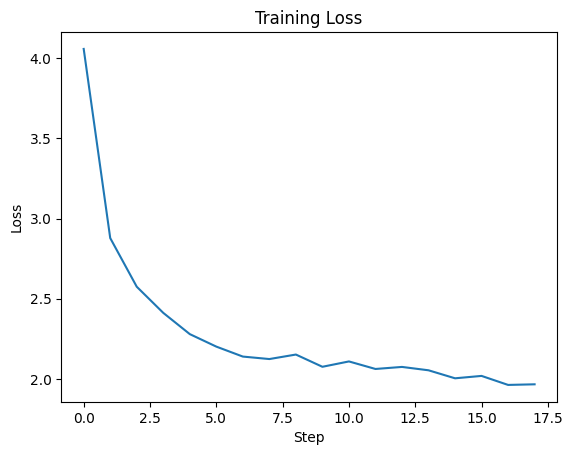

In [ ]:
import matplotlib.pyplot as plt
plt.plot(metrics_history['train_loss'])
plt.title('Training Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.show()

As you can see, the model goes from generating completely random words at the beginning to generating sensible tiny stories at the end of the training. So essentially we have pretrained a small LLM to write tiny stories for us.

## Debugging the model

When working with JAX and JIT-compiled functions, debugging requires different techniques than traditional Python debugging. Since JIT compilation traces your function and compiles it to XLA, standard `print()` statements execute at trace time and won't work inside compiled functions.

**JAX debugging tools:**

- **`jax.debug.print()`**: Print intermediate values from inside JIT-compiled functions
- **`jax.debug_nans`**: Automatically detect and raise errors when NaN values appear in computations

For more debugging techniques, see the [JAX debugging documentation](https://jax.readthedocs.io/en/latest/debugging/index.html).

Let's explore these debugging techniques with our miniGPT model.

### Using `jax.debug.print()` inside JIT-compiled functions

The `jax.debug.print()` function lets you inspect intermediate values during execution. Unlike regular `print()`, it works inside `@jax.jit` decorated functions. This is invaluable for understanding what's happening inside your model.

In [ ]:
# Demonstrate jax.debug.print inside a JIT-compiled function
@jax.jit
def debug_forward_pass(model, inputs):
    """Forward pass with debug prints to inspect intermediate values."""
    # Inspect input shape (static and known, so use Python print)
    print("Input shape:", inputs.shape)

    # Get embeddings and inspect
    x = model.embedding_layer(inputs)
    jax.debug.print("After embedding - mean: {mean:.4f}, std: {std:.4f}",
                    mean=jnp.mean(x), std=jnp.std(x))

    # Pass through transformer blocks
    for i, block in enumerate(model.transformer_blocks.layers):
        x = block(x, training=False)
        jax.debug.print("After block {i} - mean: {mean:.4f}, std: {std:.4f}",
                        i=i, mean=jnp.mean(x), std=jnp.std(x))

    logits = model.output_layer(x)
    jax.debug.print("Output logits - mean: {mean:.4f}",
                    mean=jnp.mean(logits))
    return logits

# Run the debug forward pass with a sample input
sample_input = jnp.ones((1, maxlen), dtype=jnp.int32)
_ = debug_forward_pass(model, sample_input)

Input shape: (1, 128)
After embedding - mean: -0.0091, std: 0.2439
After block 0 - mean: -0.0005, std: 0.7882
After block 1 - mean: 0.0241, std: 0.7797
After block 2 - mean: 0.0026, std: 0.7188


### Detecting NaN and Inf values with `jax.debug_nans` and `jax.debug_infs`

Exploding gradients during training can lead to either NaN ("Not a Number") or Inf (infinity) values, both of which can disrupt training and indicate numerical instability.

JAX provides configuration flags to help catch these issues early: `jax_debug_nans` will automatically detect and raise an error if NaN values appear in your computations, and `jax_debug_infs` does the same for Inf values. Both can be invaluable tools for debugging numerical problems in your model.

For more on detecting NaN and Inf in JAX computations, see the [Debugging runtime values](https://jax.readthedocs.io/en/latest/debugging/index.html)
and the [JAX debugging flags](https://docs.jax.dev/en/latest/debugging/flags.html) for information on useful flags like `jax_debug_nans` and `jax_debug_infs`.

In [ ]:
# Enable NaN debugging globally - any NaN will raise an error with a traceback
# This is useful during development to catch numerical issues early
jax.config.update("jax_debug_nans", True)

# Example: This function would raise an error if it produced NaN
@jax.jit
def safe_forward_pass(model, inputs):
    """Forward pass that will error if NaN is produced."""
    logits = model(inputs)
    # Contrived example: taking log of a negative number to induce NaN and demonstrate the NaN checker.
    logits = jnp.log(-jnp.abs(logits))
    return logits

sample_input = jnp.ones((1, maxlen), dtype=jnp.int32)

try:
    _ = safe_forward_pass(model, sample_input)
    print("Forward pass completed without NaN values")
except FloatingPointError as e:
    print("NaN detected during forward pass! (as expected for demonstration)")
    print(e)

# Disable NaN debugging for the rest of the notebook
# (It adds overhead and can slow down training)
jax.config.update("jax_debug_nans", False)

After block 3 - mean: 0.0208, std: 1.5434
Output logits - mean: -11.1983
Invalid nan value encountered in the output of a jax.jit function. Calling the de-optimized version.
Invalid nan value encountered in the output of a jax.jit function. Calling the de-optimized version.
NaN detected during forward pass! (as expected for demonstration)
invalid value (nan) encountered in log


**Tip:** You can also use `jax.debug.print()` inside your loss function or training step to monitor gradient health and intermediate values. This is demonstrated in the code cell above showing the forward pass with debug prints.

## Orbax: Save and restore model checkpoints

[Orbax](https://orbax.readthedocs.io/) is Google's checkpointing library designed for JAX workloads. It provides efficient, scalable, and flexible checkpoint management for machine learning models.

**Why Orbax?**

- **JAX-native**: Designed specifically for JAX's pytree structures and distributed arrays
- **Asynchronous saving**: Non-blocking checkpoint saves that don't interrupt training
- **Scalable**: Handles large models efficiently with support for sharded checkpoints across devices
- **Flexible**: Works with any pytree structure, including Flax NNX models
- **Cloud-ready**: Integrates with cloud storage backends like Google Cloud Storage (GCS)

**Key concepts:**

In this tutorial, we use:

1. **`nnx.state()`**: Extracts the model's state (parameters, batch stats, etc.) as a pytree
2. **`PyTreeCheckpointer`**: The main checkpointer class for saving and loading pytrees
3. **`PyTreeSave` / `PyTreeRestore`**: Arguments specifying how to save or restore the checkpoint

Let's save our trained model checkpoint.

In [ ]:
import orbax.checkpoint as orbax

state = nnx.state(model)

checkpointer = orbax.PyTreeCheckpointer()
checkpointer.save('/content/save', args=orbax.args.PyTreeSave(state), force=True)

# Make sure the files are there
!ls /content/save/

array_metadatas       d		      _METADATA        _sharding
_CHECKPOINT_METADATA  manifest.ocdbt  ocdbt.process_0


### Restoring a checkpoint

To resume training or use a saved model for inference, restore the checkpoint using `PyTreeRestore`. The restored state can be applied to a new model instance using `nnx.update()`.

In [ ]:
# Restore the checkpoint with proper sharding info
from orbax.checkpoint import checkpoint_utils

# Create restore args from the target state to provide sharding info
restore_args = checkpoint_utils.construct_restore_args(state)
restored_state = checkpointer.restore(
    '/content/save',
    args=orbax.args.PyTreeRestore(state, restore_args=restore_args)
)

# Create a fresh model instance and update it with restored state
with jax.set_mesh(mesh):
    restored_model = create_model(rngs=nnx.Rngs(42))  # Different seed to prove restoration works
    nnx.update(restored_model, restored_state)

# Verify restoration works by generating text
print("Text generated by restored model:")
_ = restored_model.generate_text(maxlen, start_tokens)

Text generated by restored model:
Once upon a time there was a very persistent little girl named Lily. She loved to sing and sing all day long. One day, her mom said she couldn't sing because it got very dirty. 
Lily was sad because her mom told her it was important to go to the park. 
But then, Lily realized that she couldn't sing a beautiful song. It was her favorite color was too much better than the little girl. 
Lily realized that it was important to listen to her mom and sing songs. She sang every day and sang songs every day. 
But one day, Lily went back into!!!!

## Tunix: Fine-tuning

[Tunix](https://github.com/google/tunix) is a JAX-native LLM post-training library open sourced by Google. It supports a range of post-training techniques including supervised finetuning, preference tuning, reinforcement learning and model distillation. In this section, we are going to use Tunix to finetune the miniGPT model we just pretrained using LoRA ([Low-Rank Adaptation](https://arxiv.org/abs/2106.09685)) so that the finetuned model generates output of a different style.

First we install Tunix and its dependencies, and import necessary libraries. Note that Colab will ask you to restart the runtime, but you can just ignore it.

**Note:** this section assume multiple TPU cores. Free-tier Colab TPU v5e-1 cannot run here.

In [ ]:
!pip install -Uq google-tunix[prod]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.0/201.0 kB 8.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2026.1.0 requires fsspec==2026.1.0, but you have fsspec 2025.10.0 which is incompatible.


In [ ]:
import qwix
import numpy as np
from tunix.sft import peft_trainer

We set some hyperparameters.

In [ ]:
# LoRA Hyperparameters
lora_rank = 16
lora_alpha = 2.0
lora_max_steps = 400
lora_num_epochs = 20
lora_batch_size = 80

For LoRA fintuning we use the [Tiny Shakespeare](https://www.tensorflow.org/datasets/catalog/tiny_shakespeare) dataset.

In [ ]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt -O TinyShakespeare.txt

def load_shakespeare_dataset(batch_size, max_len, num_epochs):
    input_file = "TinyShakespeare.txt"
    # Read the entire text file
    with open(input_file, 'r', encoding='utf-8') as f:
        text = f.read()

    # Tokenize the entire text (assuming tokenizer is available in scope)
    tokens = tokenizer.encode(text)

    # Create a simple data source from the tokens
    class TokenDataSource(pygrain.RandomAccessDataSource):
        def __init__(self, tokens, max_len):
            self._tokens = np.array(tokens, dtype=np.int32)
            self._max_len = max_len
            # Calculate how many sequences we can create
            self._length = len(self._tokens) // max_len

        def __len__(self):
            return self._length

        def __getitem__(self, index):
            # Return a sequence of max_len tokens
            start_idx = index * self._max_len
            end_idx = start_idx + self._max_len
            return self._tokens[start_idx:end_idx]

    # Create the data source
    data_source = TokenDataSource(tokens, max_len)

    # Create a sampler
    sampler = pygrain.IndexSampler(
        num_records=len(data_source),
        shuffle=True,
        seed=42,
        num_epochs=num_epochs,
        shard_options=pygrain.NoSharding()
    )

    # Create transformations
    class ToTrainingInputDict(pygrain.MapTransform):
        def map(self, batch):
            return {
                "input_tokens": batch,
                "input_mask": np.ones_like(batch)
            }

    # Create the data loader
    loader = pygrain.DataLoader(
        data_source=data_source,
        sampler=sampler,
        operations=[
            pygrain.Batch(batch_size=batch_size, drop_remainder=True),
            ToTrainingInputDict(),
        ],
        worker_count=0,  # Use main thread
    )

    def to_training_input(loader):
        # The trainer expects an iterable of `peft_trainer.TrainingInput`.
        for item in loader:
            yield peft_trainer.TrainingInput(**item)

    return to_training_input(loader)

lora_train_ds = load_shakespeare_dataset(lora_batch_size, maxlen, lora_num_epochs)

--2026-02-06 14:45:23--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘TinyShakespeare.txt’

TinyShakespeare.txt 100%[===================>]   1.06M  --.-KB/s    in 0.03s   

2026-02-06 14:45:23 (32.0 MB/s) - ‘TinyShakespeare.txt’ saved [1115394/1115394]



We define a few helper functions to create the LoRA model, loss, etc.

In [ ]:
def get_lora_model(base_model, mesh):
  lora_provider = qwix.LoraProvider(
      # Target only feed-forward layers (standard 2D linear layers)
      # Note: MultiHeadAttention uses LinearGeneral with 3D weights,
      # which qwix LoRA doesn't support
      module_path=".*linear1|.*linear2",
      rank=lora_rank,
      alpha=lora_alpha,
  )

  model_input = base_model.get_model_input()
  lora_model = qwix.apply_lora_to_model(
      base_model, lora_provider, rngs=nnx.Rngs(0), **model_input
  )

  with jax.set_mesh(mesh):
    state = nnx.state(lora_model)
    pspecs = nnx.get_partition_spec(state)
    sharded_state = jax.lax.with_sharding_constraint(state, pspecs)
    nnx.update(lora_model, sharded_state)

  return lora_model

def gen_model_input_fn(x: peft_trainer.TrainingInput):
  return {
      'inputs': x.input_tokens,
      'training': True
  }

def lora_loss_fn(model, inputs, training):
    inputs = inputs
    targets = jnp.concatenate([inputs[:, 1:], jnp.zeros((inputs.shape[0], 1), dtype=jnp.int32)], axis=1)
    logits = model(inputs, training=training)
    loss = optax.softmax_cross_entropy_with_integer_labels(logits=logits, labels=targets).mean()
    return loss

Now we can start the finetuning.

In [ ]:
print("Starting LoRA Finetuning...")
with jax.set_mesh(mesh):
    # Apply LoRA to the model
    lora_model = get_lora_model(model, mesh)

    # Setup Tunix PeftTrainer
    training_config = peft_trainer.TrainingConfig(
        eval_every_n_steps=None,
        max_steps=lora_max_steps,
        data_sharding_axis=('batch',),
    )
    lora_optimizer = optax.adamw(1e-2)
    lora_trainer = peft_trainer.PeftTrainer(
        lora_model, lora_optimizer, training_config
    ).with_gen_model_input_fn(gen_model_input_fn).with_loss_fn(lora_loss_fn)

    # Run LoRA training
    lora_trainer.train(lora_train_ds)

Starting LoRA Finetuning...


Training:   0%|          | 0/400 [00:00<?, ?step/s]

In [ ]:
# Generate text with LoRA-finetuned model
print("Generating text after LoRA finetuning:\n\n")
lora_model.generate_text(maxlen, start_tokens)

Generating text after LoRA finetuning:


Once upon a time; but the best
That you do, that, that I may be again.

DUCHOMCOMO:
I will not be sad to give him a soul,
I will be sad.

S?!"
COM:
You have had no more!

BOMY:
I'll not tell me again, but my dear or in the sun.

DUESY:
I must not to be a woman, but your head,
And I will find him.

Jucks!.
HINGFallBELLI Card:
!!!!

'Once upon a time; but the best\nThat you do, that, that I may be again.\n\nDUCHOMCOMO:\nI will not be sad to give him a soul,\nI will be sad.\n\nS?!"\nCOM:\nYou have had no more!\n\nBOMY:\nI\'ll not tell me again, but my dear or in the sun.\n\nDUESY:\nI must not to be a woman, but your head,\nAnd I will find him.\n\nJucks!.\nHINGFallBELLI Card:\n!!!!'

## Xprof: Profiling for hyperparameter tuning

[Xprof](https://openxla.org/xprof) (integrated via TensorBoard's profiler plugin) is essential for understanding and optimizing JAX/TPU performance. Profiling helps identify bottlenecks and guides hyperparameter decisions.

**Why profile your training?**

- **Identify bottlenecks**: See whether you're limited by compute, memory, or host-device communication
- **Optimize utilization**: Maximize FLOPS utilization on expensive accelerators
- **Compare configurations**: Quantitatively evaluate different batch sizes, parallelism strategies, etc.
- **Debug performance**: Understand why training is slower than expected

**Key profiling concepts:**

1. **FLOPS Utilization**: Percentage of theoretical compute capacity being used (higher is better)
2. **Step Time**: Time per training step (lower is better, but consider batch size)
3. **Trace Viewer**: Visual timeline showing operations on each device
4. **Memory Profile**: Track memory usage to avoid out-of-memory (OOM) errors

**How to profile in JAX:**

JAX provides built-in profiling through `jax.profiler`:
- `jax.profiler.start_trace(log_dir)`: Begin recording a trace
- `jax.profiler.StepTraceAnnotation`: Annotate training steps for easier analysis
- `jax.profiler.stop_trace()`: Stop recording and save the trace to disk

The traces can be visualized using TensorBoard with the profiler plugin.

**Note:** This section assumes multiple TPU cores. Free-tier Colab TPU v5e-1 cannot run these examples.

In [ ]:
!pip install -Uq tensorboard-plugin-profile tensorflow tensorboard

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 4.5.0 requires fsspec[http]<=2025.10.0,>=2023.1.0, but you have fsspec 2026.1.0 which is incompatible.


Load the tensorboard colab extension.

In [ ]:
%load_ext tensorboard

As we're going to be running this model a number of times, we need some scaffolding to more easily compare our work. For a baseline, we'll need to perform some warmup to guarantee that our code is JIT'd and that our TPUs are warm. For improved comparability, we'll only start tracing after we've finished warmup.

In [ ]:
trace_dir = "/tmp/jax-trace/"

In [ ]:
def loop_step(batch, step):
    input_batch = jnp.array(jnp.array(batch).T)
    target_batch = prep_target_batch(input_batch)
    with jax.set_mesh(mesh):
        sharded_batch = jax.device_put(
            (input_batch, target_batch),
            NamedSharding(mesh, P("batch", None))
        )
        train_step(model, optimizer, metrics, sharded_batch)

def generate_trace():
    tracing_steps = 30
    warmup_steps = 5
    for current_step in range(warmup_steps + tracing_steps):
        if current_step == warmup_steps:
            jax.profiler.start_trace(trace_dir)
        with jax.profiler.StepTraceAnnotation("train", step_num=current_step):
            batch = next(text_dl)
            loop_step(batch, current_step)

    jax.profiler.stop_trace()

Now we'll perform some traces to compare results of different batch sizes. This will take several minutes as we need to reprocess our input data to prepare new batches each time.

In [ ]:
batch_size = 32
text_dl = iter(load_and_preprocess_data('TinyStories-train.txt', batch_size, maxlen))
generate_trace()

batch_size = 128
text_dl = iter(load_and_preprocess_data('TinyStories-train.txt', batch_size, maxlen))
generate_trace()

Loaded 589,692 stories
Loaded 589,692 stories


Run Tensorboard with the Profiler Plugin to compare our runs. Runs are listed in order from newest to oldest, so the top run in the list will be have `batch_size = 128`.

The key metrics to focus on here for this hyperparameter are FLOPS Utilization and Average Step Time.

In general, we want to maximize FLOPS Utilization while minimizing the step time per training example. In this case, we can see that increasing the batch size from `32` -> `128` achieves both of those.

In [ ]:
%tensorboard --logdir=/tmp/jax-trace/

## Inference with vLLM

After training a language model, you need an efficient way to serve it for inference. While our simple `generate_text()` method works for experimentation, production deployments require optimizations like batched inference, KV-cache management, and continuous batching.

[vLLM](https://docs.vllm.ai/) is a high-throughput inference engine that addresses these challenges:

**Why vLLM?**

- **PagedAttention**: Efficient memory management for KV-cache, reducing memory waste by up to 90%
- **Continuous batching**: Dynamically batches incoming requests for higher throughput
- **Optimized kernels**: Hardware-specific optimizations for fast inference
- **Simple API**: Just a few lines of code to serve any HuggingFace model

**Basic vLLM usage:**

```python
# Install: pip install vllm
from vllm import LLM, SamplingParams

# Load a model (downloads from HuggingFace automatically)
llm = LLM(model="distilgpt2")

# Configure generation parameters
sampling_params = SamplingParams(
    temperature=0.8,
    top_p=0.95,
    max_tokens=100,
)

# Generate text - vLLM handles batching automatically
prompts = ["Once upon a time", "The quick brown fox"]
outputs = llm.generate(prompts, sampling_params)

for output in outputs:
    print(f"Prompt: {output.prompt!r}")
    print(f"Generated: {output.outputs[0].text!r}")
```

**Serving our trained miniGPT model:**

To use our JAX-trained miniGPT with vLLM, we need to convert it to a format vLLM understands. There are two approaches:

**Option 1: Convert to HuggingFace format**

Save the model weights and config in HuggingFace format, then load with vLLM:

```python
# Save miniGPT in HuggingFace format
from transformers import GPT2Config, GPT2LMHeadModel
import torch

# Create HF config matching our architecture
config = GPT2Config(
    vocab_size=vocab_size,
    n_positions=maxlen,
    n_embd=embed_dim,
    n_layer=num_transformer_blocks,
    n_head=num_heads,
)

# Create HF model and copy weights from JAX
hf_model = GPT2LMHeadModel(config)
# ... (copy weights from JAX arrays to PyTorch tensors)

# Save and load with vLLM
hf_model.save_pretrained("./minigpt-hf")
llm = LLM(model="./minigpt-hf")
```

**Option 2: Use vLLM's JAX/TPU support**

For TPU deployment, vLLM provides a [dedicated TPU backend](https://docs.vllm.ai/projects/tpu/):

```python
# Install vLLM TPU: follow https://docs.vllm.ai/projects/tpu/
from vllm import LLM

# vLLM TPU supports JAX models directly
llm = LLM(model="./minigpt-jax", device="tpu")
```

**Note:** vLLM requires a dedicated GPU or TPU runtime and cannot run in the same Python session after JAX has been initialized with a different backend. To experiment with vLLM, start a fresh runtime.

For more details, see the [vLLM documentation](https://docs.vllm.ai/) and [vLLM TPU guide](https://docs.vllm.ai/projects/tpu/).

## Summary

Congratulations! You've successfully trained a miniGPT language model from scratch using JAX and its AI ecosystem. Let's recap what you've accomplished:

**Key accomplishments:**

- **Built a transformer architecture** using Flax NNX's intuitive, Pythonic API
- **Loaded data efficiently** with Grain's high-performance data pipeline
- **Trained with Optax** using the Adam optimizer and cross-entropy loss
- **Leveraged parallelism** with JAX's automatic SPMD for data and tensor parallelism
- **Debugged your model** using `jax.debug.print()` and `jax.debug_nans`
- **Saved checkpoints** using Orbax for model persistence
- **Fine-tuned with LoRA** using Tunix for parameter-efficient adaptation
- **Profiled performance** with Xprof to optimize hyperparameters
- **Explored production inference** with vLLM for high-throughput serving

**JAX AI Stack libraries used:**

| Library | Purpose |
| :------ | :------ |
| [JAX](https://jax.readthedocs.io) | High-performance array computing with automatic differentiation |
| [Flax NNX](https://flax.readthedocs.io) | Neural network definition with intuitive API |
| [Optax](https://optax.readthedocs.io) | Gradient processing and optimization |
| [Grain](https://google-grain.readthedocs.io) | Efficient data loading |
| [Orbax](https://orbax.readthedocs.io) | Checkpoint management |
| [Tunix](https://github.com/google/tunix) | LLM fine-tuning (LoRA, RLHF, etc.) |

**Next steps:**

- **Scale up**: Try larger model dimensions, more transformer blocks, or longer sequences
- **Experiment with datasets**: Train on different text corpora for varied outputs
- **Explore advanced techniques**: Implement learning rate schedules, gradient clipping, or mixed precision training
- **Deploy to production**: Integrate your model with vLLM for production serving

**Additional resources:**

- [JAX Documentation](https://jax.readthedocs.io)
- [Flax NNX Guide](https://flax.readthedocs.io/en/latest/nnx_basics.html)
- [JAX AI Stack Tutorials](https://docs.jaxstack.ai)
- [Google Cloud TPU Documentation](https://cloud.google.com/tpu/docs)
- [vLLM TPU Documentation](https://docs.vllm.ai/projects/tpu/)